# Establishing a Good Distance Between Flu Sequences

First we need to establish the meaning of a distance between Influenza sequences. We will look at a special subset of the data where we know roughly what the similarity/distance is bewtween a pair. 

## Jaccard with k-grams

We will run k-grams and bag of "words" on the sequences and cross validate and see if the ones who are similar match our domain knowledge/possible labels. This will tell us if we have a good representation.

In [3]:
import pickle
import gzip
import numpy as np
import pandas as pd
import numba
from collections import Counter
from itertools import product
from FASTA_parse import sequence

In [36]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100
plt.style.use('seaborn')

In [32]:
# read in the sequences
with gzip.open('influenza.fna.pklz', 'rb') as fin:
    fna = pickle.load(fin)

In [6]:
fna_meta, fna_seq = fna.get_dataframe()

There are several duplicate sequences so we will remove them because they are irrelevent. It does not matter which one we keep either.

In [7]:
fna_seq.drop_duplicates(subset='Sequence', inplace=True)

Now we need to define a way of tokenizing the sequences so that we can create a word count vector. We also need to generate a dictionary that hold all the possible "words".

In [8]:
def tokenize(seq, grams=5):
    split = [seq[i:i+grams] for i in range(len(seq)-grams+1)]
    return split

def generate_vocab(grams=2):
     # generate general "vocab" list
    vocab = Counter()
    for t in product('ACTG', 'ACTG', repeat=grams):
        s = []
        for i in range(grams):
            s.append(t[i])
        vocab[''.join(s)] = 0
        
    return vocab

def generate_vec(seq_list, vocab, grams, r):
    new_vec_col = []
    for seq in seq_list:
        vec = vocab.copy()
        tokens = tokenize(seq, grams=grams)
        for j, gram in enumerate(tokens):
            vec[gram] += 1
            
        new_vec_col.append(np.array(vec.values(), dtype=np.int8))
        
    return new_vec_col
    
def generate_bag(seq_df, grams=2, r=0):
    # generate general "vocab" list
    vocab = generate_vocab(grams)
    
    new_vec = np.zeros(shape=(seq_df.shape[0], 4**grams))
    
    for i, seq in enumerate(seq_df.Sequence):
        vec = vocab.copy()
        for j, gram in enumerate(tokenize(seq, grams=grams)):
            if gram in vec:
                vec[gram] += 1
        
        new_vec[i] = np.array(list(vec.values()), dtype=np.int8)
    
    return new_vec
                    

We generate the vectors on a sample of the data of size 1000.

In [7]:
BOW_5 = generate_bag(fna_seq.sample(1000), grams=4)

### Using a library
We will now use a library from sklearn that will accomplish the same thing, but it is vectorized. This means we can easily increase our sample from 1000 to 10000. Then we will use a KMeans library to cluster them. If we want to use a different distance (e.g. cosine distance) we would have to implement our own clustering.

In [9]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import CountVectorizer

In [53]:
k=6
sample = fna_seq.sample(10000)
vectorizer = CountVectorizer(analyzer='char', ngram_range=(k-2,k+1))
X = vectorizer.fit_transform(sample.Sequence.tolist())

Note: We can also use a vector that has more than k-gram tokens, e.g. we can use $k=5,6$.

In [54]:
# the sequences have some characters that don't hold very much information so we filter them out entirely.
import re
idxs = []
for i,token in enumerate(vectorizer.get_feature_names()):
    if re.match('^[actg]+$', token):
        idxs.append(i)
        
features = np.array(vectorizer.get_feature_names())[idxs]
X = X.toarray()[:,idxs]

### KMeans
Now we will attempt to run KMeans on our now generated vectors. We will look at the cost and see where k should be. We will most likely need to do some dimensionality reduction to improve our performance.

In [55]:
# MiniBatchKMeans!!
inert = np.zeros(shape=(20-2))

for k in range(2,20):
    km = MiniBatchKMeans(k, max_iter=500, batch_size=1000)
    km.fit_predict(X)
    inert[k-2] = km.inertia_
    print(km.inertia_)
    
inert

69626472.8949
65538262.6317
59153345.1199
56077279.6872
52573693.6473
48933285.2744
49106321.3382
46241057.8364
44103947.3546
42905390.8963
41614452.739
41345460.3865
39314305.836
38243291.1159
37318835.7676
36467731.0385
35405458.0165
34612870.7818


array([ 69626472.89491455,  65538262.63170243,  59153345.11991724,
        56077279.68717642,  52573693.64725573,  48933285.27442709,
        49106321.33820021,  46241057.83639647,  44103947.35460287,
        42905390.89633445,  41614452.73896447,  41345460.38648136,
        39314305.8359592 ,  38243291.11588058,  37318835.76760831,
        36467731.03853165,  35405458.01651169,  34612870.78184067])

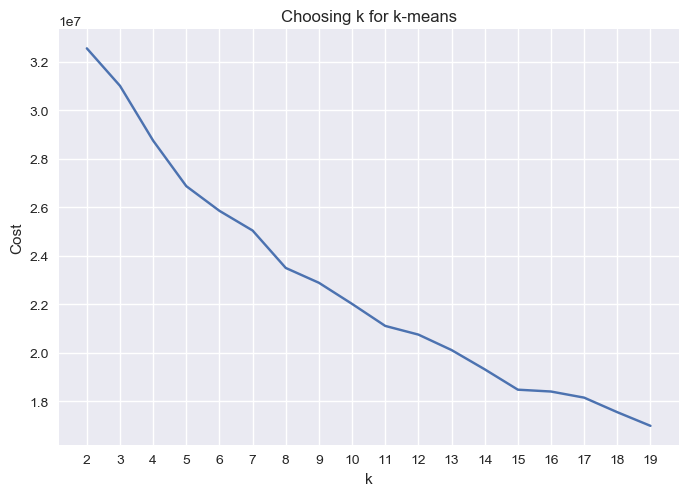

In [37]:
plt.plot(np.arange(2,20,1), inert)
plt.xticks(np.arange(2,20,1))
plt.title('Choosing k for k-means')
plt.xlabel('k')
plt.ylabel('Cost')
plt.savefig('choosing_k.jpg', dpi=300, pad_inches=.01)

Since out KMeans cost was so high we will see if there are actually any clusters by using PCA. We will plot the 1st, 2nd, and 3rd PC's in a 2D plane.

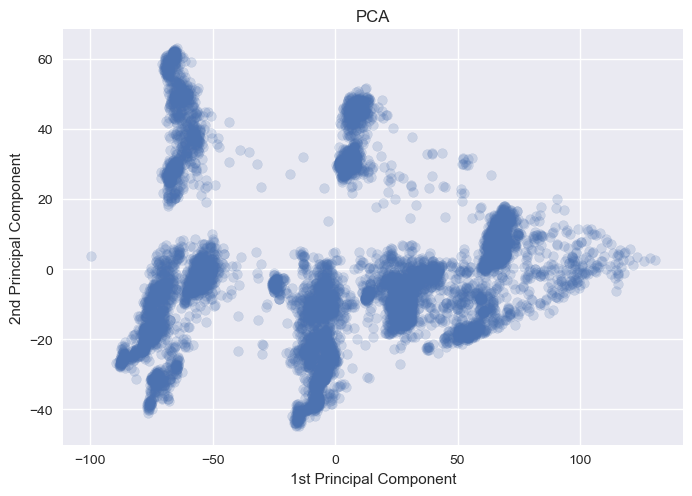

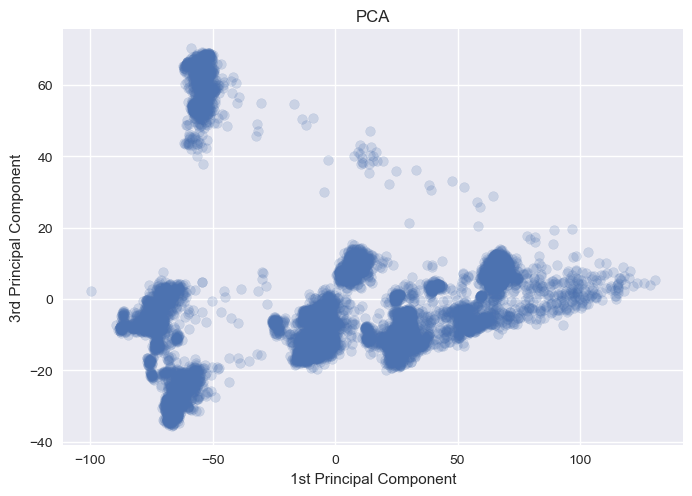

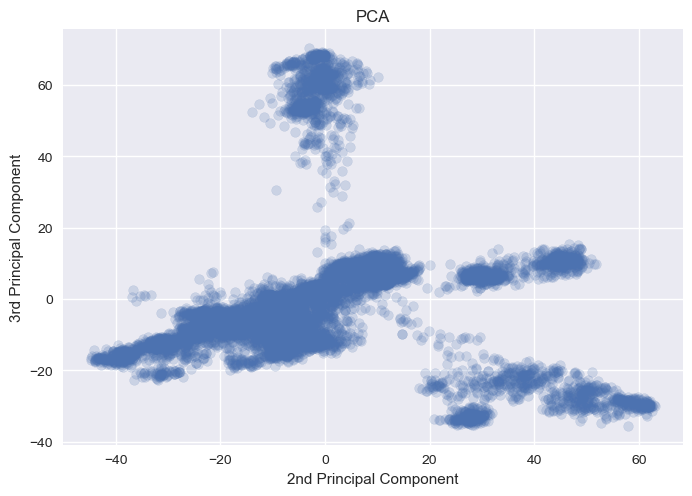

In [56]:
# TODO extract gene type and see if clusters correspond to the different genes
from sklearn.decomposition import PCA

pca = PCA(n_components=200)
new_X = pca.fit_transform(X)

plt.scatter(new_X[:,0], new_X[:,1], alpha=.2)
plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')
plt.title('PCA')
plt.show()

plt.scatter(new_X[:,0], new_X[:,2], alpha=.2)
plt.xlabel('1st Principal Component')
plt.ylabel('3rd Principal Component')
plt.title('PCA')
plt.show()

plt.scatter(new_X[:,1], new_X[:,2], alpha=.2)
plt.xlabel('2nd Principal Component')
plt.ylabel('3rd Principal Component')
plt.title('PCA')
plt.show()

In [44]:
new_X.shape

(10000, 150)

In [57]:
# MiniBatchKMeans!!
inert = []

for k in range(2,25):
    km = MiniBatchKMeans(k, max_iter=500, batch_size=1000)
    km.fit_predict(new_X)
    inert.append(km.inertia_)
    
inert

[62135719.408191308,
 54999589.741442792,
 52201622.697522931,
 49537432.2262647,
 44819480.281142175,
 42973691.394271687,
 39327465.862618826,
 38421700.282465279,
 35658824.10591507,
 34814569.035979554,
 32904219.051273745,
 32927144.228356503,
 31707461.79029581,
 30636918.902900744,
 28864848.215485495,
 27780609.289373539,
 26903544.637439538,
 26366004.995634489,
 25537399.463520143,
 24977555.074536379,
 24598583.863479298,
 23386876.302098975,
 23195846.131022356]

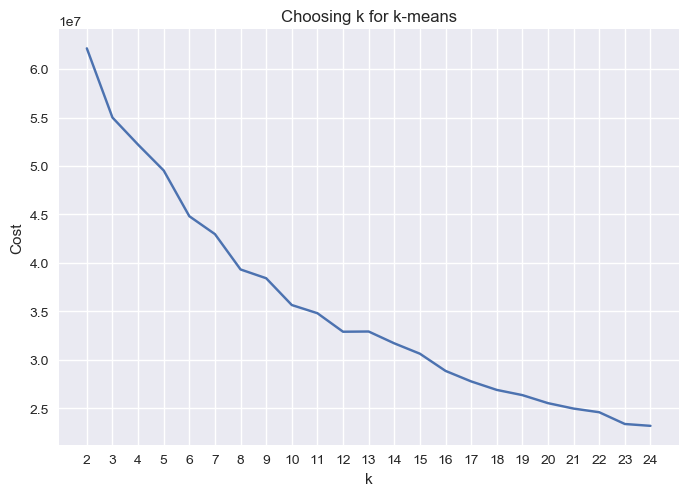

In [58]:
plt.plot(np.arange(2,25,1), inert)
plt.xticks(np.arange(2,25,1))
plt.title('Choosing k for k-means')
plt.xlabel('k')
plt.ylabel('Cost')
plt.savefig('choosing_k.jpg', dpi=300, pad_inches=.01)